<div style="margin-bottom: 32px;">
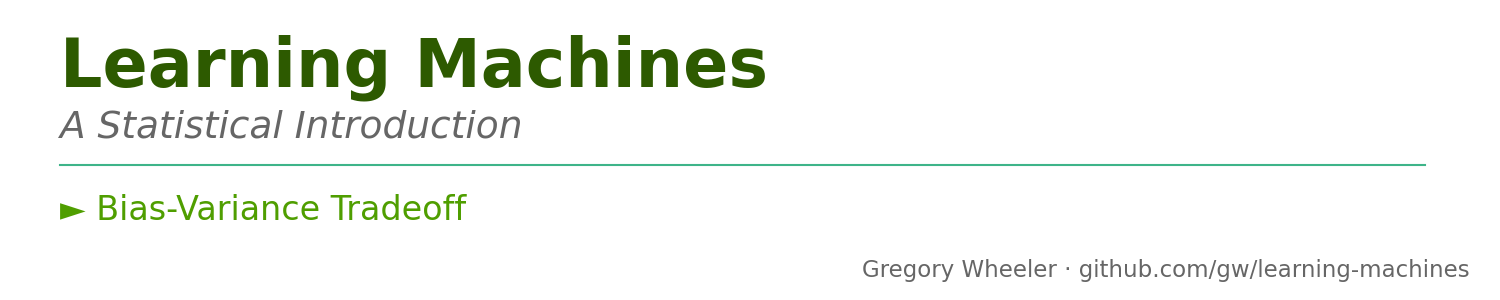
</div>


# The Bias-Variance Tradeoff

The bias-variance decomposition reveals *why* model complexity matters: simple models are biased but stable; complex models are flexible but erratic. This notebook makes the tradeoff tangible by simulating it directly—training thousands of models on different samples and watching bias and variance emerge from the statistics.

**What computation adds**: The textbook proves the decomposition; here we *measure* it. By repeatedly sampling data and fitting models, we see bias and variance as empirical quantities, not just terms in an equation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import warnings
import sys
from pathlib import Path

# Suppress polyfit conditioning warnings (expected with high-degree polynomials)
warnings.filterwarnings('ignore', category=np.RankWarning)

# Add the notebook directory to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt

# Apply the style and set notebook mode (green palette)
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

# For reproducibility
np.random.seed(42)

---
## 1. The Prediction Error Decomposition

When we make predictions, our expected error can be decomposed into three components:

$$\mathbb{E}[(y - \hat{f}(x))^2] = \underbrace{\text{Bias}^2}_{\text{systematic error}} + \underbrace{\text{Variance}}_{\text{model instability}} + \underbrace{\sigma^2}_{\text{irreducible noise}}$$

where:
- **Bias**: How far off is the average prediction from the true value?
- **Variance**: How much do predictions vary across different training sets?
- **Irreducible error** ($\sigma^2$): Noise inherent in the data that no model can capture

---
## 2. The Dartboard Analogy

A helpful way to understand bias and variance is the dartboard analogy:
- **Low bias, low variance**: Darts clustered around the bullseye
- **High bias, low variance**: Darts clustered but off-center
- **Low bias, high variance**: Darts scattered but centered on bullseye
- **High bias, high variance**: Darts scattered and off-center

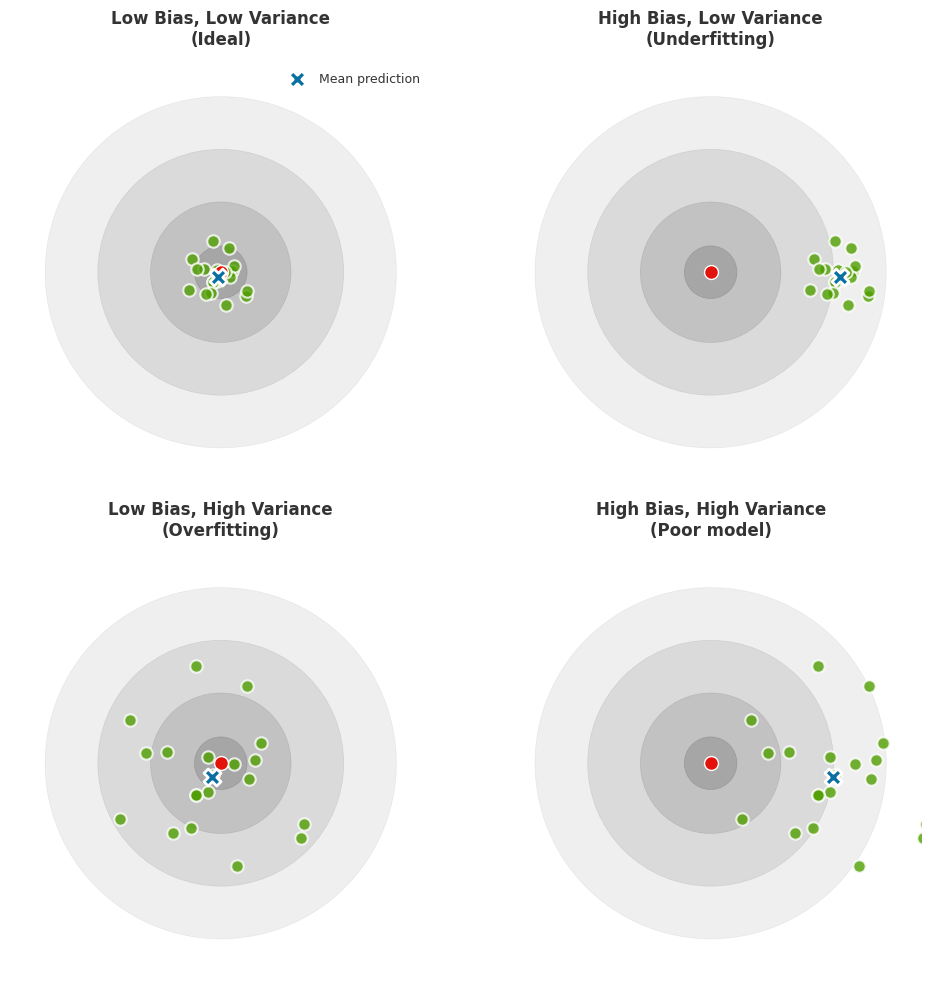

In [2]:
def plot_dartboard(ax, bias, variance, title, n_darts=20):
    """Plot dartboard visualization of bias-variance."""
    np.random.seed(42)
    
    # Draw dartboard
    for r, alpha in [(1.0, 0.1), (0.7, 0.15), (0.4, 0.2), (0.15, 0.3)]:
        circle = plt.Circle((0, 0), r, fill=True, color=mt.GRAY, alpha=alpha)
        ax.add_patch(circle)
    
    # Bullseye
    ax.plot(0, 0, 'o', color=mt.RED, markersize=10, zorder=5)
    
    # Generate dart positions
    # Bias shifts the center, variance controls spread
    std = np.sqrt(variance) * 0.3
    x_darts = np.random.normal(bias * 0.5, std, n_darts)
    y_darts = np.random.normal(0, std, n_darts)
    
    # Plot darts
    ax.scatter(x_darts, y_darts, c=mt.GREEN, s=80, edgecolors='white',
               linewidths=1.5, zorder=4, alpha=0.8)
    
    # Plot mean of darts
    ax.scatter(x_darts.mean(), y_darts.mean(), c=mt.BLUE, s=150,
               marker='X', edgecolors='white', linewidths=2, zorder=5,
               label='Mean prediction')
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.axis('off')

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

plot_dartboard(axes[0, 0], bias=0, variance=0.1, title='Low Bias, Low Variance\n(Ideal)')
plot_dartboard(axes[0, 1], bias=1.5, variance=0.1, title='High Bias, Low Variance\n(Underfitting)')
plot_dartboard(axes[1, 0], bias=0, variance=1.0, title='Low Bias, High Variance\n(Overfitting)')
plot_dartboard(axes[1, 1], bias=1.5, variance=1.0, title='High Bias, High Variance\n(Poor model)')

# Add legend to first plot
axes[0, 0].legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

---
## 3. Demonstrating Bias-Variance with Polynomial Regression

Let's see how model complexity (polynomial degree) affects bias and variance.

We'll:
1. Generate data from a known true function
2. Fit models of different complexity to many training sets
3. Observe how predictions vary

In [3]:
def true_function(x):
    """The true underlying function (unknown in practice)."""
    return np.sin(2 * np.pi * x)

def generate_data(n_samples, noise_std=0.3, seed=None):
    """Generate noisy observations from the true function."""
    if seed is not None:
        np.random.seed(seed)
    x = np.random.uniform(0, 1, n_samples)
    y = true_function(x) + np.random.normal(0, noise_std, n_samples)
    return x, y

def fit_polynomial(x, y, degree):
    """Fit polynomial and return coefficients."""
    return np.polyfit(x, y, degree)

def predict_polynomial(x, coeffs):
    """Predict using polynomial coefficients."""
    return np.polyval(coeffs, x)

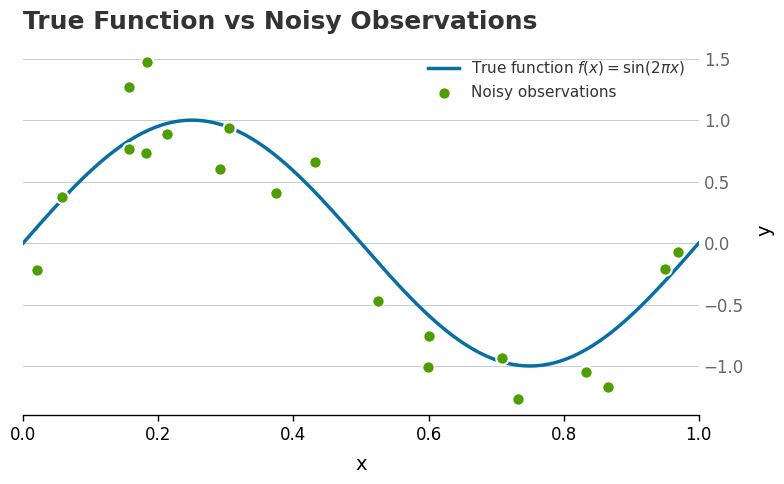

In [4]:
# Visualize the true function and some noisy samples
x_true = np.linspace(0, 1, 200)
y_true = true_function(x_true)

x_sample, y_sample = generate_data(20, noise_std=0.3, seed=42)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(x_true, y_true, c=mt.BLUE, linewidth=2.5, label='True function $f(x) = \sin(2\pi x)$')
ax.scatter(x_sample, y_sample, c=mt.GREEN, s=80, edgecolors='white',
           linewidths=1.5, label='Noisy observations', zorder=3)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('True Function vs Noisy Observations', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_xlim(0, 1)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

---
## 4. Multiple Training Sets: Seeing Variance

The key to understanding variance is to imagine training on **many different datasets** drawn from the same distribution. Each dataset gives a different fitted model.

In [5]:
def fit_many_models(degree, n_datasets=50, n_samples=20, noise_std=0.3):
    """
    Fit polynomial models to many different training datasets.
    
    Returns predictions on a fixed test grid for each model.
    """
    x_test = np.linspace(0, 1, 100)
    all_predictions = []
    
    for seed in range(n_datasets):
        x_train, y_train = generate_data(n_samples, noise_std, seed=seed)
        coeffs = fit_polynomial(x_train, y_train, degree)
        y_pred = predict_polynomial(x_test, coeffs)
        all_predictions.append(y_pred)
    
    return x_test, np.array(all_predictions)

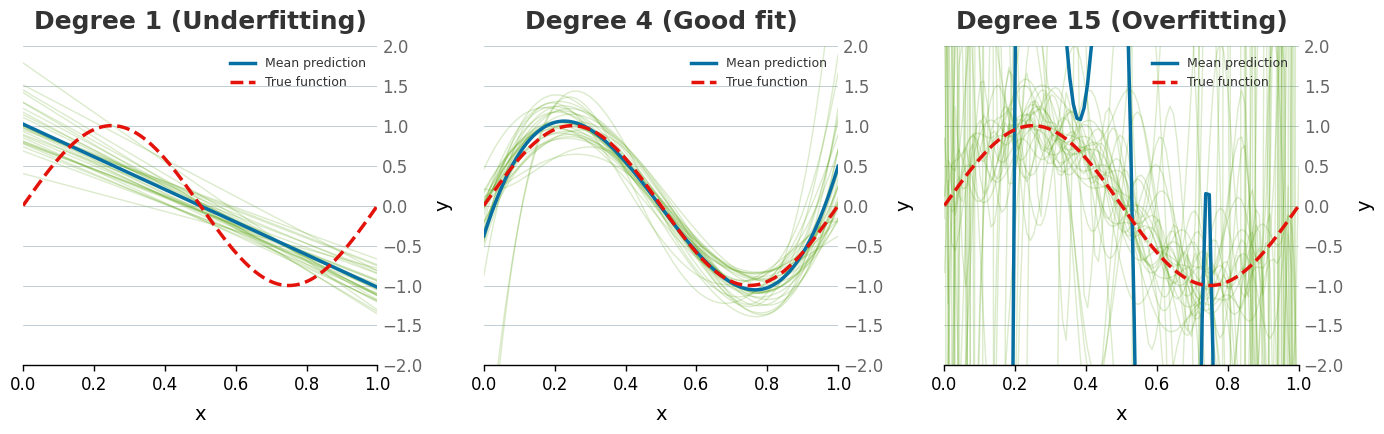

In [6]:
# Compare low complexity (degree 1) vs high complexity (degree 15)
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

degrees = [1, 4, 15]
titles = ['Degree 1 (Underfitting)', 'Degree 4 (Good fit)', 'Degree 15 (Overfitting)']

for ax, degree, title in zip(axes, degrees, titles):
    x_test, all_preds = fit_many_models(degree, n_datasets=30, n_samples=20)
    
    # Plot all fitted models (showing variance)
    for i, preds in enumerate(all_preds):
        ax.plot(x_test, preds, c=mt.GREEN, alpha=0.2, linewidth=1)
    
    # Plot mean prediction
    mean_pred = all_preds.mean(axis=0)
    ax.plot(x_test, mean_pred, c=mt.BLUE, linewidth=2.5, label='Mean prediction')
    
    # Plot true function
    ax.plot(x_test, true_function(x_test), c=mt.RED, linewidth=2.5, 
            linestyle='--', label='True function')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 2)
    ax.legend(loc='upper right', fontsize=9)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Observations:**
- **Degree 1 (left)**: Low variance (lines clustered), but high bias (mean far from true function)
- **Degree 4 (middle)**: Good balance — mean prediction tracks true function, moderate variance
- **Degree 15 (right)**: Low bias at training points, but extremely high variance (wild oscillations)

---
## 5. Computing Bias and Variance

Let's explicitly compute bias² and variance at each point:

$$\text{Bias}^2(x) = (\mathbb{E}[\hat{f}(x)] - f(x))^2$$

$$\text{Variance}(x) = \mathbb{E}[(\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2]$$

In [7]:
def compute_bias_variance(degree, n_datasets=100, n_samples=20, noise_std=0.3):
    """
    Compute bias², variance, and expected error for a polynomial model.
    """
    x_test = np.linspace(0, 1, 100)
    y_true = true_function(x_test)
    
    # Fit many models
    _, all_preds = fit_many_models(degree, n_datasets, n_samples, noise_std)
    
    # Mean prediction at each point
    mean_pred = all_preds.mean(axis=0)
    
    # Bias² at each point
    bias_squared = (mean_pred - y_true) ** 2
    
    # Variance at each point
    variance = all_preds.var(axis=0)
    
    # Average over all test points
    avg_bias_squared = bias_squared.mean()
    avg_variance = variance.mean()
    
    # Irreducible error
    irreducible = noise_std ** 2
    
    # Total expected error
    total_error = avg_bias_squared + avg_variance + irreducible
    
    return {
        'bias_squared': avg_bias_squared,
        'variance': avg_variance,
        'irreducible': irreducible,
        'total': total_error,
        'x_test': x_test,
        'bias_squared_curve': bias_squared,
        'variance_curve': variance
    }

In [8]:
# Compute for different model complexities
degrees = range(1, 16)
results = []

print(f"{'Degree':>6} {'Bias²':>10} {'Variance':>10} {'Irreducible':>12} {'Total':>10}")
print("-" * 52)

for d in degrees:
    r = compute_bias_variance(d, n_datasets=100, n_samples=20, noise_std=0.3)
    results.append(r)
    if d <= 5 or d >= 13:
        print(f"{d:>6} {r['bias_squared']:>10.4f} {r['variance']:>10.4f} {r['irreducible']:>12.4f} {r['total']:>10.4f}")
    elif d == 6:
        print(f"{'...':>6}")

Degree      Bias²   Variance  Irreducible      Total
----------------------------------------------------
     1     0.2064     0.0299       0.0900     0.3263
     2     0.2148     0.1042       0.0900     0.4089
     3     0.0069     0.0361       0.0900     0.1330
     4     0.0136     0.0933       0.0900     0.1970
     5     0.0038     0.2483       0.0900     0.3421
   ...
    13 6929641.9859 746652485.1480       0.0900 753582127.2239
    14 1490132052.3741 152006430653.7187       0.0900 153496562706.1828
    15 1063717426.3310 76214466141.7148       0.0900 77278183568.1358


/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)


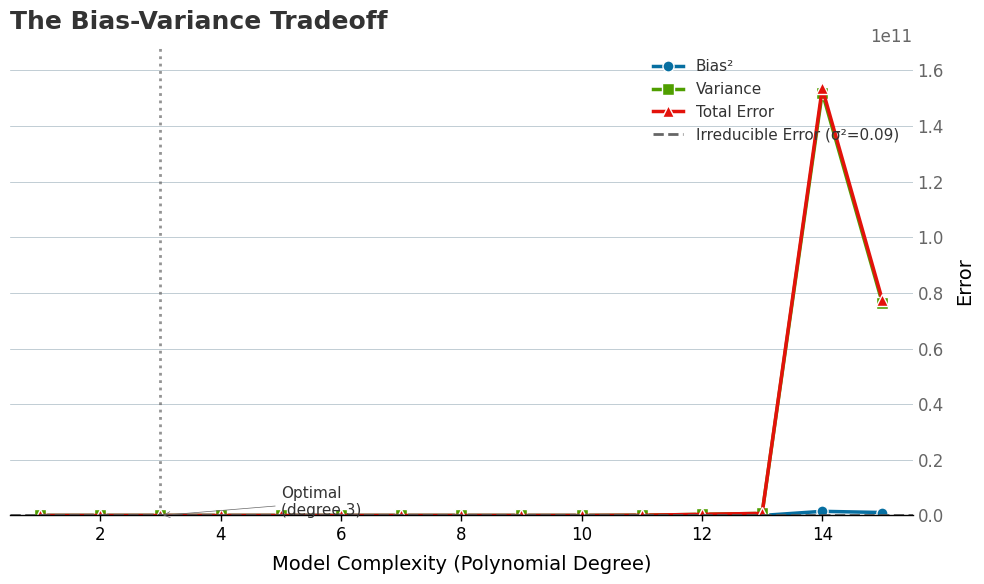

In [9]:
# Plot bias-variance tradeoff
fig, ax = plt.subplots(figsize=(10, 6))

bias_sq = [r['bias_squared'] for r in results]
variance = [r['variance'] for r in results]
total = [r['total'] for r in results]
irreducible = results[0]['irreducible']

ax.plot(degrees, bias_sq, 'o-', c=mt.BLUE, linewidth=2.5, markersize=8, label='Bias²')
ax.plot(degrees, variance, 's-', c=mt.GREEN, linewidth=2.5, markersize=8, label='Variance')
ax.plot(degrees, total, '^-', c=mt.RED, linewidth=2.5, markersize=8, label='Total Error')
ax.axhline(y=irreducible, color=mt.GRAY, linestyle='--', linewidth=2, 
           label=f'Irreducible Error (σ²={irreducible:.2f})')

# Mark optimal complexity
optimal_idx = np.argmin(total)
ax.axvline(x=degrees[optimal_idx], color=mt.GRAY, linestyle=':', alpha=0.7)
ax.annotate(f'Optimal\n(degree {degrees[optimal_idx]})', 
            xy=(degrees[optimal_idx], total[optimal_idx]),
            xytext=(degrees[optimal_idx] + 2, total[optimal_idx] + 0.1),
            fontsize=11, arrowprops=dict(arrowstyle='->', color=mt.GRAY))

ax.set_xlabel('Model Complexity (Polynomial Degree)')
ax.set_ylabel('Error')
ax.set_title('The Bias-Variance Tradeoff', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_xlim(0.5, 15.5)
ax.set_ylim(0, max(total) * 1.1)

mt.apply_economist_style(ax)
plt.tight_layout()
plt.show()

**The classic tradeoff:**
- As complexity increases, **bias decreases** (model can fit more patterns)
- As complexity increases, **variance increases** (model is more sensitive to training data)
- **Total error** has a U-shape with an optimal complexity in the middle
- We can never do better than the **irreducible error** (the noise floor)

---
## 6. Spatial Distribution of Bias and Variance

Bias and variance aren't uniform across the input space. Let's visualize where each dominates.

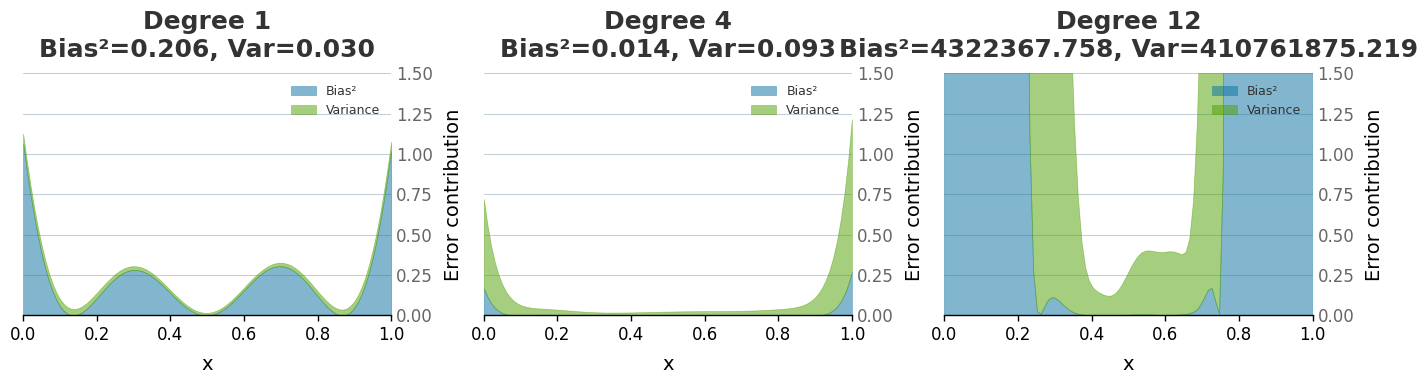

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, degree, title in zip(axes, [1, 4, 12], ['Degree 1', 'Degree 4', 'Degree 12']):
    r = compute_bias_variance(degree, n_datasets=100)
    
    ax.fill_between(r['x_test'], 0, r['bias_squared_curve'], 
                    alpha=0.5, color=mt.BLUE, label='Bias²')
    ax.fill_between(r['x_test'], r['bias_squared_curve'], 
                    r['bias_squared_curve'] + r['variance_curve'],
                    alpha=0.5, color=mt.GREEN, label='Variance')
    
    ax.set_xlabel('x')
    ax.set_ylabel('Error contribution')
    ax.set_title(f"{title}\nBias²={r['bias_squared']:.3f}, Var={r['variance']:.3f}", 
                 fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.5)
    ax.legend(loc='upper right', fontsize=9)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

---
## 7. Effect of Training Set Size

More data generally helps reduce variance (but not bias). Let's see how training set size affects the tradeoff.

In [11]:
def compute_bv_vs_samples(degree, sample_sizes, n_datasets=100, noise_std=0.3):
    """Compute bias-variance for different training set sizes."""
    results = []
    for n in sample_sizes:
        x_test = np.linspace(0, 1, 100)
        y_true = true_function(x_test)
        
        all_preds = []
        for seed in range(n_datasets):
            x_train, y_train = generate_data(n, noise_std, seed=seed)
            try:
                coeffs = fit_polynomial(x_train, y_train, degree)
                y_pred = predict_polynomial(x_test, coeffs)
                # Clip extreme predictions for numerical stability
                y_pred = np.clip(y_pred, -10, 10)
                all_preds.append(y_pred)
            except:
                continue
        
        all_preds = np.array(all_preds)
        mean_pred = all_preds.mean(axis=0)
        
        bias_sq = ((mean_pred - y_true) ** 2).mean()
        var = all_preds.var(axis=0).mean()
        
        results.append({'n': n, 'bias_squared': bias_sq, 'variance': var})
    
    return results

/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/

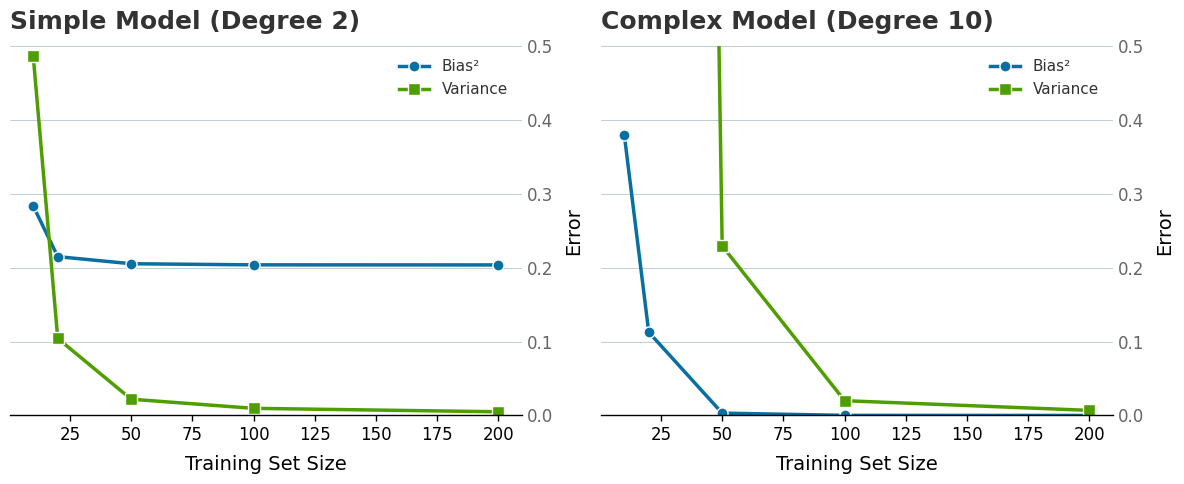

In [12]:
sample_sizes = [10, 20, 50, 100, 200]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# For a simple model (degree 2)
ax = axes[0]
results_d2 = compute_bv_vs_samples(2, sample_sizes)
ns = [r['n'] for r in results_d2]
bias_d2 = [r['bias_squared'] for r in results_d2]
var_d2 = [r['variance'] for r in results_d2]

ax.plot(ns, bias_d2, 'o-', c=mt.BLUE, linewidth=2.5, markersize=8, label='Bias²')
ax.plot(ns, var_d2, 's-', c=mt.GREEN, linewidth=2.5, markersize=8, label='Variance')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Error')
ax.set_title('Simple Model (Degree 2)', fontweight='bold', loc='left')
ax.legend()
ax.set_ylim(0, 0.5)
mt.apply_economist_style(ax)

# For a complex model (degree 10)
ax = axes[1]
results_d10 = compute_bv_vs_samples(10, sample_sizes)
bias_d10 = [r['bias_squared'] for r in results_d10]
var_d10 = [r['variance'] for r in results_d10]

ax.plot(ns, bias_d10, 'o-', c=mt.BLUE, linewidth=2.5, markersize=8, label='Bias²')
ax.plot(ns, var_d10, 's-', c=mt.GREEN, linewidth=2.5, markersize=8, label='Variance')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Error')
ax.set_title('Complex Model (Degree 10)', fontweight='bold', loc='left')
ax.legend()
ax.set_ylim(0, 0.5)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Key insights:**
- **More data reduces variance** — with more examples, models are less sensitive to any particular training set
- **More data doesn't reduce bias** — a linear model fitting a sine wave will always be biased, no matter how much data
- **Complex models benefit more from additional data** — they have more variance to reduce

---
## 8. Learning Curves

**Learning curves** plot training and test error as a function of training set size. They reveal bias-variance issues:
- **High bias**: Both errors high, converge quickly, gap is small
- **High variance**: Training error low, test error high, large gap

In [13]:
def compute_learning_curve(degree, sample_sizes, noise_std=0.3, n_trials=50):
    """Compute learning curves (train/test error vs training size)."""
    # Fixed test set
    np.random.seed(999)
    x_test = np.random.uniform(0, 1, 100)
    y_test = true_function(x_test) + np.random.normal(0, noise_std, 100)
    
    train_errors = []
    test_errors = []
    
    for n in sample_sizes:
        train_err_trials = []
        test_err_trials = []
        
        for seed in range(n_trials):
            x_train, y_train = generate_data(n, noise_std, seed=seed)
            
            try:
                coeffs = fit_polynomial(x_train, y_train, degree)
                
                y_train_pred = predict_polynomial(x_train, coeffs)
                y_test_pred = predict_polynomial(x_test, coeffs)
                
                train_mse = np.mean((y_train - y_train_pred) ** 2)
                test_mse = np.mean((y_test - y_test_pred) ** 2)
                
                if train_mse < 10 and test_mse < 10:  # Filter unstable fits
                    train_err_trials.append(train_mse)
                    test_err_trials.append(test_mse)
            except:
                continue
        
        train_errors.append(np.mean(train_err_trials))
        test_errors.append(np.mean(test_err_trials))
    
    return train_errors, test_errors

/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/kh6fv52d59xcdl6hqdh5g90m0000gn/T/ipykernel_11743/3031607691.py:15: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)
/var/folders/hw/

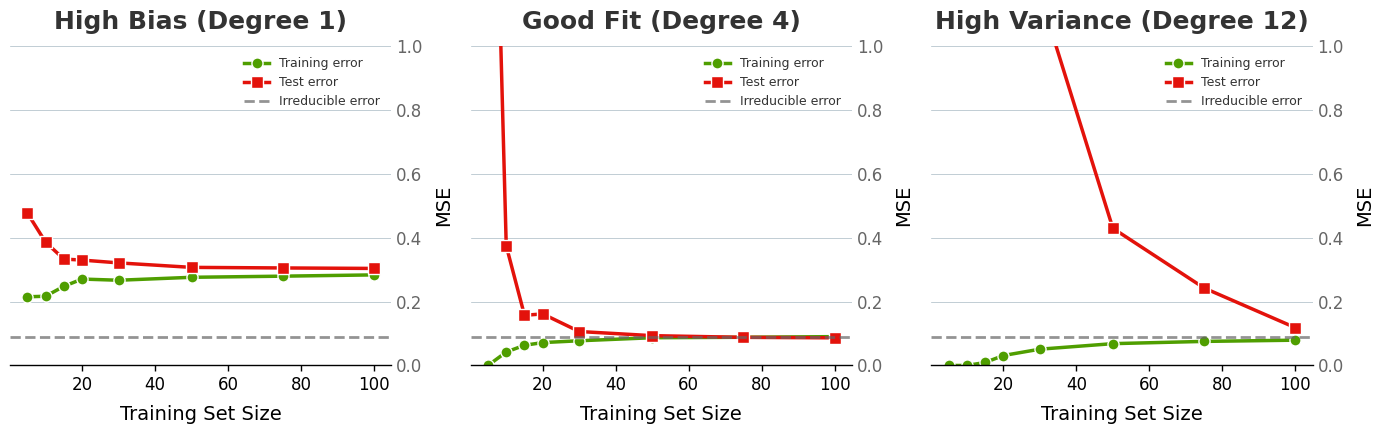

In [14]:
sample_sizes = [5, 10, 15, 20, 30, 50, 75, 100]

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

for ax, degree, title in zip(axes, [1, 4, 12], 
                              ['High Bias (Degree 1)', 'Good Fit (Degree 4)', 'High Variance (Degree 12)']):
    train_err, test_err = compute_learning_curve(degree, sample_sizes)
    
    ax.plot(sample_sizes, train_err, 'o-', c=mt.GREEN, linewidth=2.5, 
            markersize=8, label='Training error')
    ax.plot(sample_sizes, test_err, 's-', c=mt.RED, linewidth=2.5,
            markersize=8, label='Test error')
    ax.axhline(y=0.09, color=mt.GRAY, linestyle='--', alpha=0.7, 
               label='Irreducible error')
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('MSE')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(0, 1.0)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Reading learning curves:**

| Pattern | Diagnosis | Solution |
|---------|-----------|----------|
| Both errors high, small gap | High bias (underfitting) | Increase model complexity |
| Training error low, test error high | High variance (overfitting) | More data, regularization, simpler model |
| Both converge to irreducible error | Good fit | Model is well-suited to problem |

---
## 9. The Double Descent Phenomenon

In modern deep learning, researchers have observed that very high-complexity models can sometimes achieve low test error — a phenomenon called **double descent**. The classical U-shaped curve can have a second descent at very high complexity.

This is beyond our scope here, but it's worth knowing that the simple bias-variance picture has nuances in the overparameterized regime.

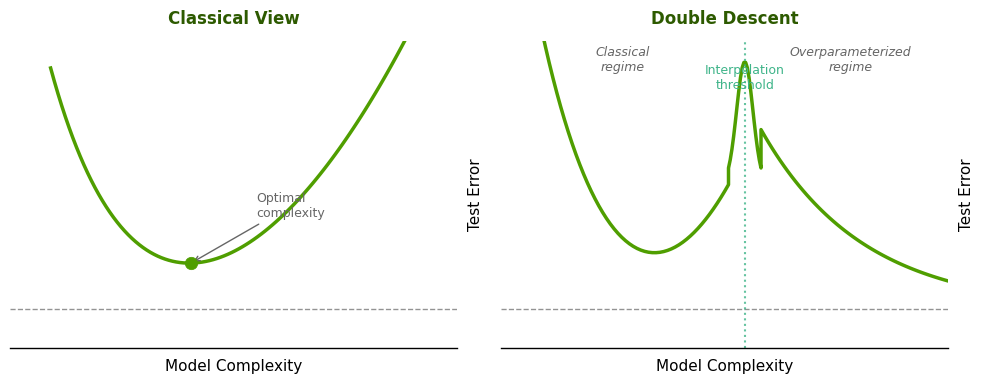

In [15]:
# Schematic: Classical vs Double Descent
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: Classical U-shaped curve
ax1 = axes[0]
x_classic = np.linspace(0.5, 5, 100)
# U-shaped curve: high at low complexity, dips, then rises
y_classic = 2.5 * np.exp(-1.2 * x_classic) + 0.15 * (x_classic - 1.5)**2 + 0.3

ax1.plot(x_classic, y_classic, color=mt.GREEN, linewidth=2.5)
ax1.axhline(y=0.25, color=mt.GRAY, linestyle='--', linewidth=1, alpha=0.7, label='Irreducible error')

# Mark the sweet spot
min_idx = np.argmin(y_classic)
ax1.scatter([x_classic[min_idx]], [y_classic[min_idx]], color=mt.GREEN, s=80, zorder=5)
ax1.annotate('Optimal\ncomplexity', xy=(x_classic[min_idx], y_classic[min_idx]), 
             xytext=(x_classic[min_idx] + 0.8, y_classic[min_idx] + 0.3),
             fontsize=9, color=mt.GRAY,
             arrowprops=dict(arrowstyle='->', color=mt.GRAY, lw=1))

ax1.set_xlabel('Model Complexity', fontsize=11)
ax1.set_ylabel('Test Error', fontsize=11)
ax1.set_title('Classical View', fontsize=12, fontweight='bold', color=mt.FOREST)
ax1.set_xlim(0, 5.5)
ax1.set_ylim(0, 2)
ax1.set_xticks([])
ax1.set_yticks([])
mt.apply_economist_style(ax1)

# Right: Double Descent curve
ax2 = axes[1]

# Build the double descent curve in segments
x1 = np.linspace(0.5, 2.8, 50)  # First descent and rise
y1 = 2.5 * np.exp(-1.2 * x1) + 0.4 * (x1 - 1.5)**2 + 0.3

x2 = np.linspace(2.8, 3.2, 20)  # Peak at interpolation threshold
y2_base = y1[-1]
y2 = y2_base + 0.8 * np.exp(-((x2 - 3.0)**2) / 0.02)

x3 = np.linspace(3.2, 5.5, 50)  # Second descent
y3_start = y2[-1]
y3 = y3_start * np.exp(-0.8 * (x3 - 3.2)) + 0.25

x_dd = np.concatenate([x1, x2, x3])
y_dd = np.concatenate([y1, y2, y3])

ax2.plot(x_dd, y_dd, color=mt.GREEN, linewidth=2.5)
ax2.axhline(y=0.25, color=mt.GRAY, linestyle='--', linewidth=1, alpha=0.7)

# Mark the interpolation threshold
ax2.axvline(x=3.0, color=mt.SEAFOAM, linestyle=':', linewidth=1.5, alpha=0.8)
ax2.text(3.0, 1.85, 'Interpolation\nthreshold', fontsize=9, color=mt.SEAFOAM, 
         ha='center', va='top')

# Label regions
ax2.text(1.5, 1.8, 'Classical\nregime', fontsize=9, color=mt.GRAY, ha='center', style='italic')
ax2.text(4.3, 1.8, 'Overparameterized\nregime', fontsize=9, color=mt.GRAY, ha='center', style='italic')

ax2.set_xlabel('Model Complexity', fontsize=11)
ax2.set_ylabel('Test Error', fontsize=11)
ax2.set_title('Double Descent', fontsize=12, fontweight='bold', color=mt.FOREST)
ax2.set_xlim(0, 5.5)
ax2.set_ylim(0, 2)
ax2.set_xticks([])
ax2.set_yticks([])
mt.apply_economist_style(ax2)

plt.tight_layout()
plt.show()

---
## Summary

**The Bias-Variance Decomposition:**
$$\text{Expected Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

**Key concepts:**
- **Bias**: Error from wrong assumptions (e.g., fitting a line to a curve)
- **Variance**: Error from sensitivity to training data fluctuations
- **Irreducible error**: Noise inherent in the problem

**The tradeoff:**
- Simple models → high bias, low variance (underfitting)
- Complex models → low bias, high variance (overfitting)
- Goal: find the sweet spot that minimizes total error

**Practical implications:**
- Use learning curves to diagnose problems
- High bias → need more complex model or better features
- High variance → need more data, regularization, or simpler model

**Next steps** (covered in the book):
- Cross-validation for model selection
- Regularization to control variance